# **Purpose**

...multilabel classification with multiple modalities...

# **Imports & Settings**

In [46]:
from utils_models import *
from utils_dataloaders import *
from utils_training import *
from models_classification import *

import json
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

##### set dataframe display options 
# show decimal format (not scientific notation)
pd.options.display.float_format = '{:.4f}'.format

# display all columns
pd.set_option('display.max_columns', None)

In [2]:
#####################
# Confirm GPU Status
#####################

if torch.cuda.is_available():
    print('GPU available...')
else:
    print('GPU NOT available...')

GPU NOT available...


# **Parameters**

In [47]:
##########################
# Setup Patches Directory
##########################

model_name = 'ResNext50_01'

# directory for model output
model_dir = f"../models/classification/{model_name}"
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
else:
    print('DIRECTORY ALREADY EXISTS!!!!')


# paths to patch GeoJSONs
train_patch_path = r'../models/patches/warren_patches_train.geojson'
val_patch_path = r'../models/patches/warren_patches_val.geojson'
test_patch_path = r'../models/patches/warren_patches_test.geojson'
hardin_test_patch_path = r'../models/patches/hardin_patches_test.geojson'


# directories where patches are stored...
patch_dir = r'../data/patches_warren'
hardin_patch_dir = r'../data/patches_hardin'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 50
out_classes = 7


# modalities to use (names with unique identifier filename substrings)...
modalities = {
    'dem': ['dem.tif'], 
    # 'rgb': ['aerialr.tif', 'aerialg.tif', 'aerialb.tif'], 
    }


# model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
encoders = {
    'dem' : ResNextEncoder(input_channels=1)
    }

attentions = {
    'self_dem' : (SelfAttentionBlock(), ['dem'])
    }

model = ClassificationModel(encoders=encoders, attentions=attentions)

optimizer = optim.Adam(model.parameters())



# focal loss...
target_path = glob.glob(r'../data/warren/*_labels.csv')[0]
targets = pd.read_csv(target_path)
targets = targets.iloc[:, 1:]
alpha = (len(targets) * out_classes) / targets.sum(axis=0).to_numpy()
alpha = alpha / alpha.sum()
alpha = np.sqrt(alpha)
alpha = torch.tensor(alpha, dtype=torch.float32).view(1, -1).to(device)
# alpha = 1
gamma = 1
reduction = 'mean'

criterion = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction)

DIRECTORY ALREADY EXISTS!!!!


In [48]:
# normalization parameters
norm_stats_path = r'../data/warren/image_stats.csv'
df = pd.read_csv(norm_stats_path)
norm_params = {}
for modality, channels in modalities.items():
    means = []
    stds = []
    for channel in channels:
        stats = df.loc[df['path']==channel]
        means.append(stats['mean'].item())
        stds.append(stats['std'].item())
    norm_params[modality] = [means, stds]


In [53]:
metadata = {}
metadata['name'] = model_name
metadata['path'] = model_dir

metadata['training'] = (train_patch_path, patch_dir)
metadata['validation'] = (val_patch_path, patch_dir)
metadata['testing'] = (test_patch_path, patch_dir)
metadata['external testing'] = [(hardin_test_patch_path, hardin_patch_dir) if not hardin_test_patch_path is None else None]

metadata['modalities'] = modalities
metadata['normalizations'] = norm_params

metadata['batch size'] = batch_size
metadata['epochs'] = num_epochs

metadata['optimizer'] = {
    "name": type(optimizer).__name__,
    "learning_rate": optimizer.param_groups[0]['lr'],
    "weight_decay": optimizer.param_groups[0].get('weight_decay', None),
    "momentum": optimizer.param_groups[0].get('momentum', None)
    }
metadata['loss'] = type(criterion).__name__
metadata['FL alpha'] = alpha.cpu().numpy().tolist() if alpha is not None else None
metadata['FL gamma'] = gamma if gamma is not None else None

metadata['encoders'] = {key: type(value).__name__ for key, value in encoders.items()}
metadata['attention'] = {key: type(value[0]).__name__ for key, value in attentions.items()}
metadata['model'] = type(model).__name__
metadata['output classes'] = out_classes

with open(f"{model_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=4)

# **DataLoaders**

In [5]:
#########################################################################
# Setup Custom Datasets and DataLoaders for Train, Validation, Test Sets
#########################################################################

##### get lists of training, validation, and test patch IDs
# training...
gdf_train = gpd.read_file(train_patch_path)
train_ids = gdf_train['patch_id'].to_list()

# validation...
gdf_val = gpd.read_file(val_patch_path)
val_ids = gdf_val['patch_id'].to_list()

# testing (Warren County)...
gdf_test = gpd.read_file(test_patch_path)
test_ids = gdf_test['patch_id'].to_list()

# testing (Hardin County)...
gdf_hardin_test = gpd.read_file(hardin_test_patch_path)
hardin_test_ids = gdf_hardin_test['patch_id'].to_list()


##### create custom datasets
train_dataset = MultiModalDataset(ids=train_ids[:64], 
                                  data_dir=patch_dir, 
                                  modalities=modalities, 
                                  norm_params=norm_params, 
                                  augment=True, 
                                  task='classification')

val_dataset = MultiModalDataset(ids=val_ids[:64], 
                                data_dir=patch_dir, 
                                modalities=modalities, 
                                norm_params=norm_params, 
                                augment=False, 
                                task='classification')

test_dataset = MultiModalDataset(ids=test_ids, 
                                 data_dir=patch_dir, 
                                 modalities=modalities, 
                                 norm_params=norm_params, 
                                 augment=False, 
                                 task='classification')

hardin_test_dataset = MultiModalDataset(ids=hardin_test_ids, 
                                        data_dir=hardin_patch_dir, 
                                        modalities=modalities, 
                                        norm_params=norm_params, 
                                        augment=False, 
                                        task='classification')

#### create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
hardin_test_loader = DataLoader(hardin_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)

## *DataLoader Example*

In [ ]:
##################
# Verify Contents
##################

# extract example
example = next(iter(train_loader))

##### print data report
for modality in example.keys():
    print(modality)
    print(f"{type(example[modality])}  |  {example[modality].dtype}  |  {example[modality].shape}  |  {example[modality].min()}  |  {example[modality].max()}")


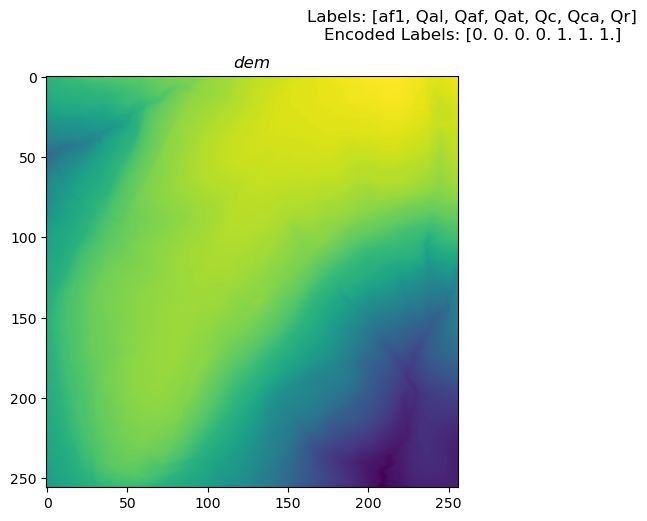

In [7]:
####################
# Visualize Example
####################

##### plot modalities & labels
ncols = 2
nrows = 1
uneven = len(modalities) % ncols
if len(modalities) > ncols:
    if not uneven:
        nrows = len(modalities) / ncols
    else:
        nrows = (len(modalities) // ncols) + 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5*nrows))
ax = ax.ravel()

idx = 0
for modality in example.keys():
    if not 'label' in modality:
        image = prep_image_for_plot(example[modality][0])
        ax[idx].imshow(image)
        ax[idx].set_title(modality, style='italic')
        idx += 1
    else:
        label_vec = example['label'][0].numpy().ravel()

if uneven:
    fig.delaxes(ax[-1])

plt.suptitle(f"Labels: [af1, Qal, Qaf, Qat, Qc, Qca, Qr]\nEncoded Labels: {label_vec}", y=1)
plt.tight_layout()
plt.show()

# **Model**

## *Training*

In [8]:
########################
# Training & Validation
#######################

##### train
train_loss, train_acc, val_loss, val_acc, best_model = train_model(model, 
                                                      train_loader, 
                                                      val_loader, 
                                                      criterion, 
                                                      optimizer, 
                                                      device, 
                                                      num_epochs, 
                                                      model_dir)

Epoch 1/2
TRAINING   -- Loss: 0.0919  |  Accuracy: 56.47%  |  Time: 0.68 mins.
VALIDATION -- Loss: 0.0920  |  Accuracy: 50.89%  |  Time: 0.3 mins.
New best model saved with loss 0.0920...
New best model saved with accuracy 50.89%...


Epoch 2/2
TRAINING   -- Loss: 0.0600  |  Accuracy: 82.14%  |  Time: 0.6 mins.
VALIDATION -- Loss: 0.0856  |  Accuracy: 78.35%  |  Time: 0.3 mins.
New best model saved with loss 0.0856...
New best model saved with accuracy 78.35%...




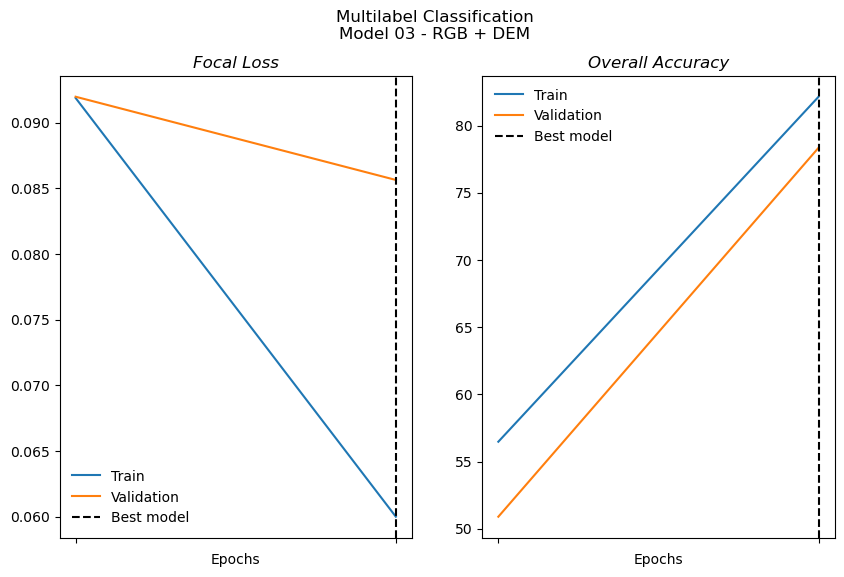

In [9]:

# output_path = r'../models/classification/model_03/training.jpg'

# best_model = 34


fig, ax = plt.subplots(ncols=2, figsize=(10,6))

epochs = range(1, len(train_loss)+1)

ax[0].plot(epochs, train_loss, label='Train')
ax[0].plot(epochs, val_loss, label='Validation')
ax[0].set_title('Focal Loss', style='italic')

ax[1].plot(epochs, train_acc, label='Train')
ax[1].plot(epochs, val_acc, label='Validation')
ax[1].set_title('Overall Accuracy', style='italic')

for axes in ax:
    axes.axvline(x=best_model, linestyle='--', color='k', label='Best model')
    axes.legend(frameon=False)
    axes.set_xticks(epochs)
    axes.set_xticklabels([str(x) if x%5==0 else '' for x in epochs])
    axes.set_xlabel('Epochs')

plt.suptitle('Multilabel Classification\nModel 03 - RGB + DEM', y=0.99)
plt.savefig(f"{model_dir}/training_results.jpg")
plt.show()


# Test

In [17]:
# parameters...
# output_dir = r'../models/classification/model_01'
# out_classes = 7
# modality_channels = {'rgb': 3, 'dem': 1}
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
all_predictions, all_targets = test_model(model, test_loader, device)

## *Per label Metrics*

In [ ]:
##### Precision, Recall, F1, AUC-ROC, Average Precision

In [20]:
df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):
    df.loc[idx, 'Class'] = unit
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=0.5)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= 0.5).sum()
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(f"{model_dir}/label_metrics.csv", index=False)
df.head(10)


,MapUnit,Targets,Predictions,Precision,Recall,F1,AUROC
0,af1,361,293,0.7952,0.6454,0.7125,0.8874
1,Qal,624,726,0.7287,0.8478,0.7837,0.7937
2,Qaf,11,0,0.0000,0.0000,0.0000,0.8497
3,Qat,41,2,0.0000,0.0000,0.0000,0.8772
4,Qc,521,479,0.9290,0.8541,0.8900,0.9666
5,Qca,315,248,0.8468,0.6667,0.7460,0.9212
6,Qr,952,995,0.9437,0.9863,0.9646,0.9144


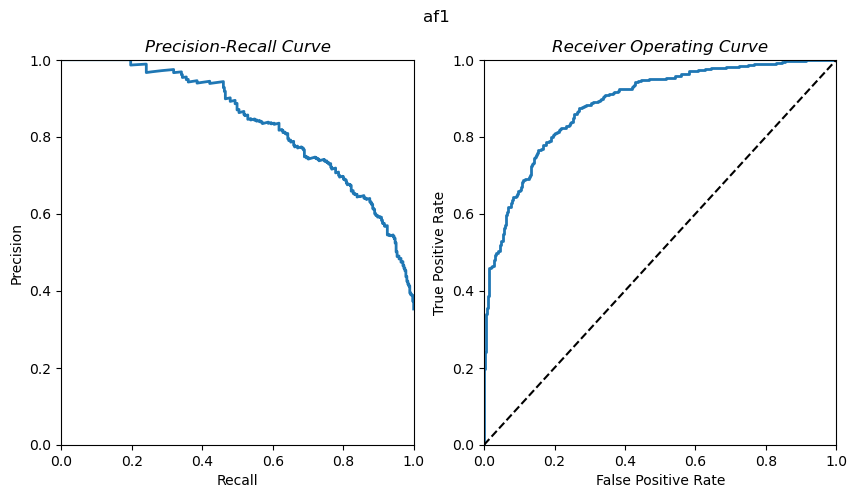

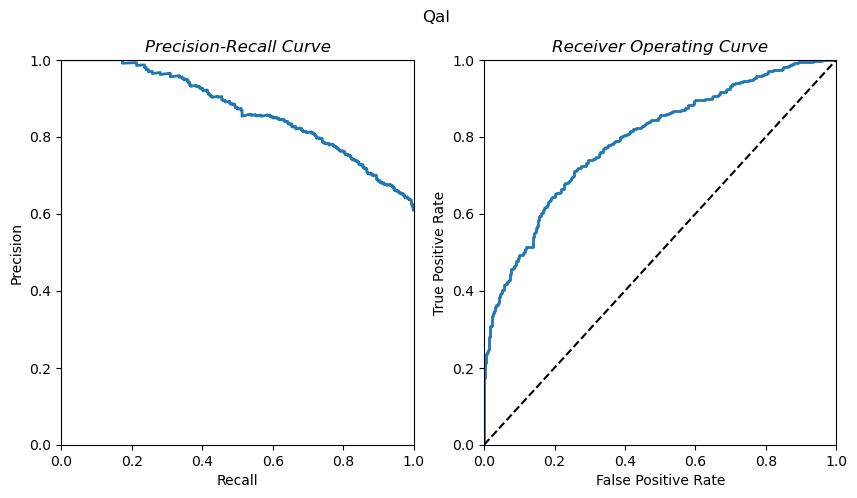

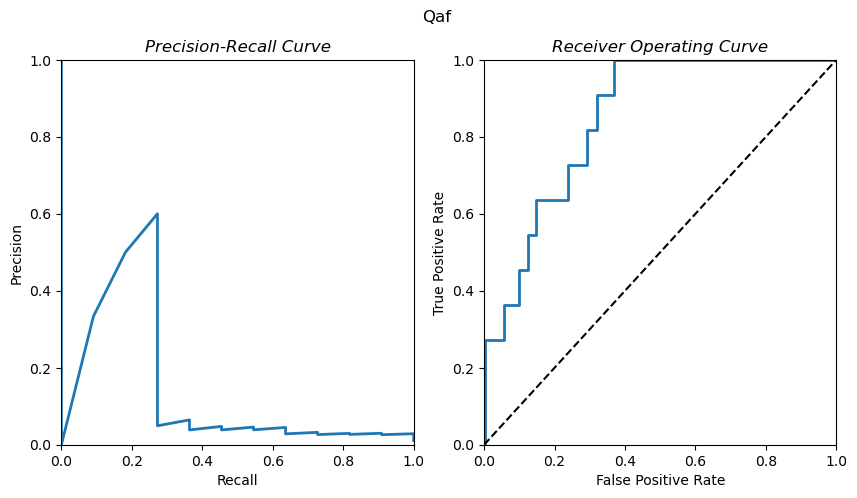

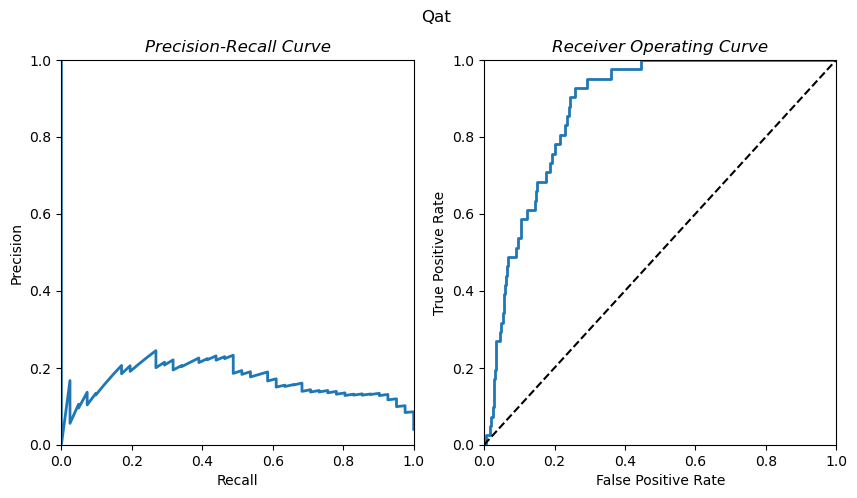

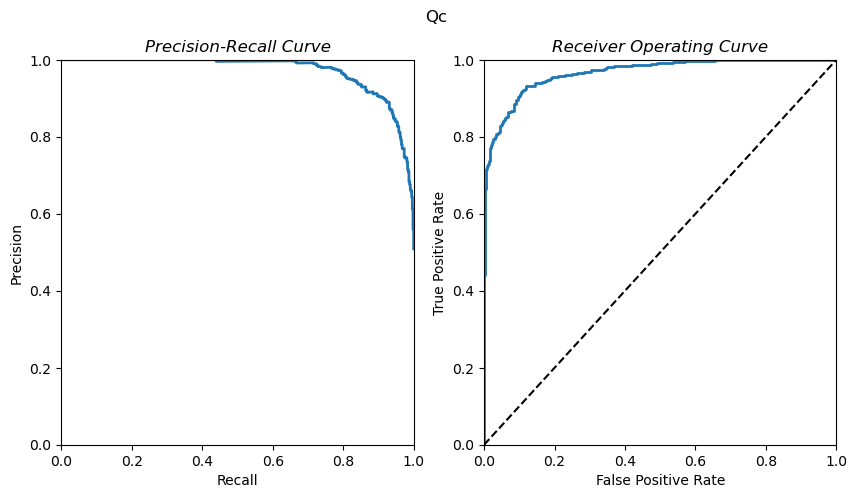

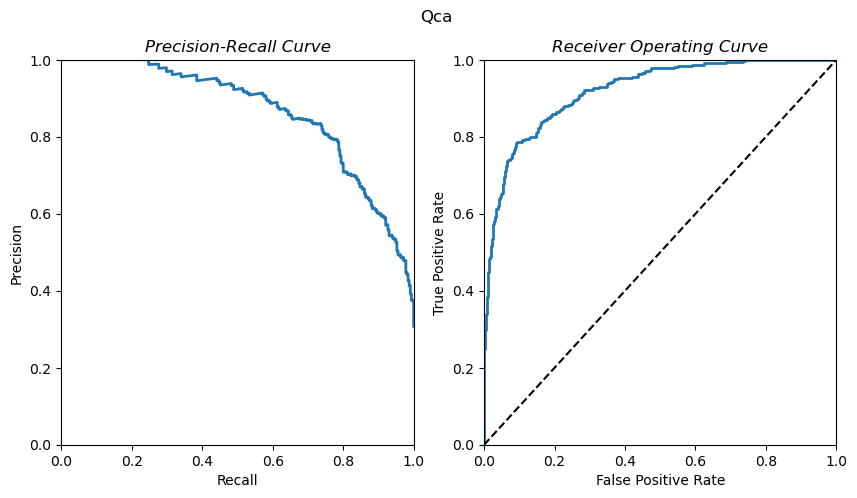

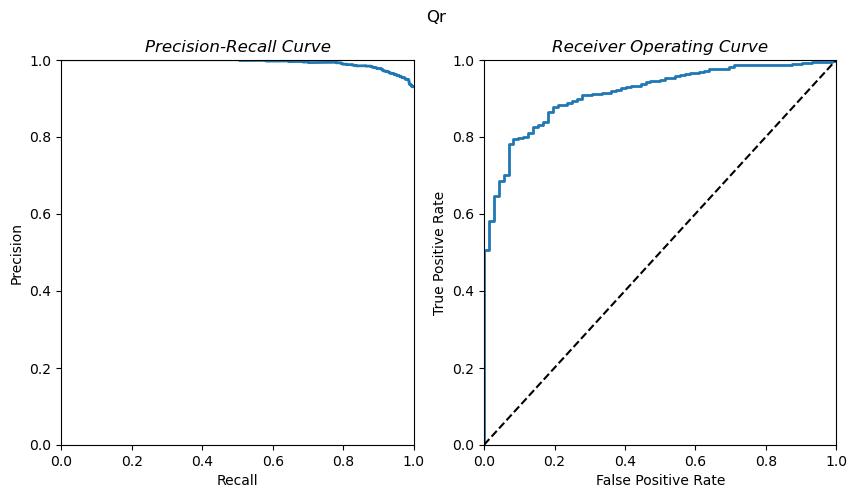

In [21]:
##### Visualizations - Precision-Recall Curve & ROC Curve

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

    fig = plot_label_pr_roc_curves(all_predictions[:,idx], all_targets[:, idx])
    plt.suptitle(unit)
    fig.savefig(f"{model_dir}/{unit}_pr_roc_curves.jpg")
    plt.show(fig)


## *Overall Metrics*

In [22]:
##### Averaged over all labels - Precision, Recall, F1, AUC-ROC, & mean Average Precision (mAP), Hamming loss, Subset Accuracy
macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=[0.5])

df = pd.DataFrame({'Macro Precision': macro_precision, 
                   'Macro Recall': macro_recall, 
                   'Macro F1': macro_f1, 
                   'mAP': mean_ap, 
                   'Hamming Loss': h_loss, 
                   'Subset Accuracy':subset_acc}, index=[0])

df.to_csv(f"{model_dir}/global_metrics.csv", index=False)
df.head()

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,MacroPrecision,MacroRecall,MacroF1,mAP,HammingLoss,SubsetAccuracy
0,0.6062,0.5715,0.5853,0.6951,0.1194,0.3994


## *Tuned Results*

In [28]:
def calculate_optimal_thresholds(model, val_loader, device):
  
  all_predictions = []
  all_targets = []

  model.eval()

  with torch.no_grad():
    for batch in val_loader:
      
      labels = batch.pop('label').squeeze(1).to(device)
      modalities = {modality: data.to(device) for modality, data in batch.items()}
      outputs = model(modalities)
      predictions = torch.sigmoid(outputs)
      all_targets.append(labels.cpu().numpy())
      all_predictions.append(predictions.cpu().numpy())
  
  all_predictions = np.concatenate(all_predictions)
  all_targets = np.concatenate(all_targets)

  optimal_thresholds = []

  for class_idx in range (all_predictions.shape[1]):
    precision, recall, thresholds = precision_recall_curve(all_targets[:, class_idx], all_predictions[:, class_idx])
    f1 = 2 * (precision * recall) / (precision + recall)
    best_idx = np.argmax(f1)
    best_threshold = thresholds[best_idx]
    optimal_thresholds.append(best_threshold)

  return optimal_thresholds

In [23]:
optimal_thresholds = calculate_optimal_thresholds(model, val_loader, device)
optimal_thresholds

c:\Users\mamass1\Documents\GitHub\cs612\code\utils_training.py:331: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)
c:\Users\mamass1\Documents\GitHub\cs612\code\utils_training.py:331: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


[0.41788006,
 0.4871445,
 0.4189473,
 0.5534512,
 0.39100426,
 0.45210084,
 0.48792765]

In [24]:
df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
    df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(f"{model_dir}/label_metrics_tuned.csv", index=False)
df.head(10)

,MapUnit,Targets,Predictions,Precision,Recall,F1,AUROC
0,af1 (0.42),361,389,0.7172,0.7729,0.7440,0.8874
1,Qal (0.49),624,764,0.7081,0.8670,0.7795,0.7937
2,Qaf (0.42),11,0,0.0000,0.0000,0.0000,0.8497
3,Qat (0.55),41,0,0.0000,0.0000,0.0000,0.8772
4,Qc (0.39),521,544,0.8897,0.9290,0.9089,0.9666
5,Qca (0.45),315,274,0.8321,0.7238,0.7742,0.9212
6,Qr (0.49),952,1000,0.9400,0.9874,0.9631,0.9144


In [25]:
macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

df = pd.DataFrame({'Macro Precision': macro_precision, 
                   'Macro Recall': macro_recall, 
                   'Macro F1': macro_f1, 
                   'mAP': mean_ap, 
                   'Hamming Loss': h_loss, 
                   'Subset Accuracy':subset_acc}, index=[0])

df.to_csv(f"{model_dir}/global_metrics_tuned.csv", index=False)
df.head()

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,MacroPrecision,MacroRecall,MacroF1,mAP,HammingLoss,SubsetAccuracy
0,0.5839,0.6114,0.5957,0.5528,0.1189,0.3828
